# photometry_plot.ipynb

開口測光したデータをプロットする。横軸は衛星のSys3経度。

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy
import ftpS3
import spiceypy as spice
spice.furnsh('kernel/cassMetaK.txt')

fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                    'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold'
                     })


# cpalette = ['#8ecae6', '#ffb703', '#023047', '#fb8500', '#219ebc']
cpalette = ['#0F4C81', '#FF6F61', '#645394',
         '#84BD00', '#F6BE00', '#F7CAC9', '#0F80E6']
cpalette = ['#184678', '#005261', '#C00000', '#E88B00', '#F25A00', '#2F397D', '#A3BDDA', '#9FC0B4', '#F3B5A8', '#EECA77', '#EFA785', '#AAACD4']
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC']

In [3]:
north_doy = ['14/006_v06', '14/013_v13', '14/016_v12', '22/271_v18', '22/274_v17']
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']

def load(csvname0):
    df = pd.read_csv(csvname0, sep='\t')
    utc = df.loc[:, 'date']                                 # UTC date
    efplat = df.loc[:, 'lat [deg]'].values                  # EFP latitude [deg]
    efpwlong = df.loc[:, 'wlong [deg]'].values              # EFP System III longitude [deg]
    moons3 = df.loc[:, 'Moon S3 [deg]'].values              # Europa's System III longitude [deg]
    final_phot_ave = df.loc[:, 'spot brightness [kR]']      # EFP brightness [kR]
    annulus_median = df.loc[:, 'local background [kR]']     # local background [kR]
    
    b0_arr = np.zeros(len(final_phot_ave))
    b1_arr = np.zeros(len(final_phot_ave))
    efplat0_arr = np.zeros(len(final_phot_ave))
    efpwlong0_arr = np.zeros(len(final_phot_ave))
    moons30_arr = np.zeros(len(final_phot_ave))
    for i in range(len(final_phot_ave)):
        if final_phot_ave[i] != '0':
            b0_arr[i] = final_phot_ave[i]
            b1_arr[i] = annulus_median[i]
            efplat0_arr[i] = efplat[i]
            efpwlong0_arr[i] = efpwlong[i]
            moons30_arr[i] = moons3[i]
        else:
            continue
    
    return utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr

JRM33計算結果

磁気赤道面crossingのSys3 [deg] 110.61452513966482

磁場成分 Br 最大のSys3 [deg] 189.05027932960894

磁気赤道面crossingのSys3 [deg] 281.56424581005587

EFPの明るさ

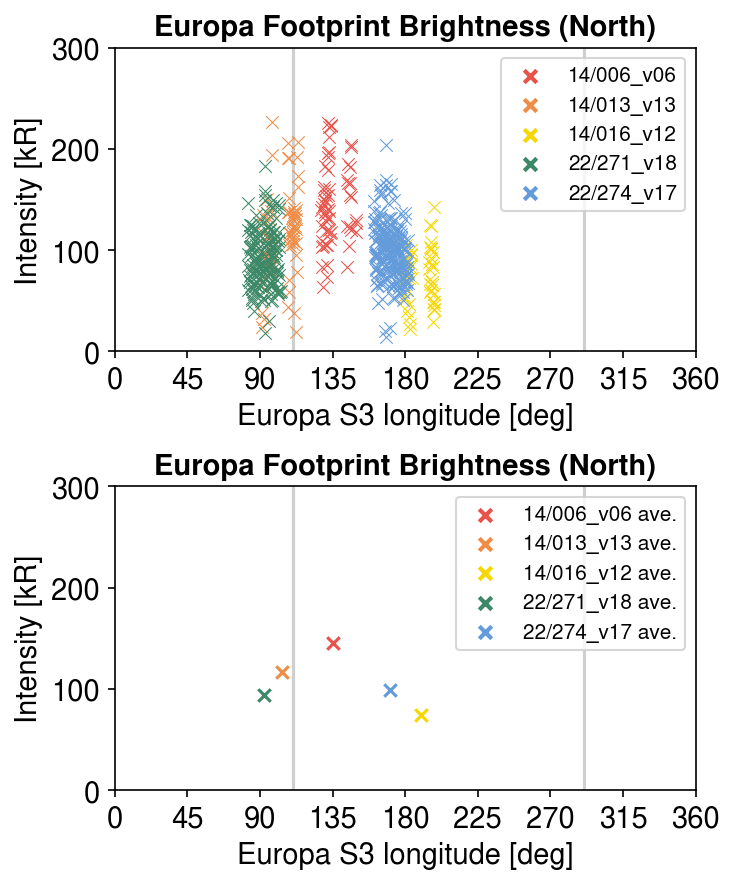

In [4]:
hem = 'North'
if hem == 'North':
    doy = north_doy
elif hem == 'South':
    doy = south_doy
else:
    doy = north_doy+south_doy

fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,6), dpi=150)
ax[0].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,300)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

ax[1].set_title('Europa Footprint Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,300)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave, marker='x', c=cpalette[i], label=doy[i]+' ave.', zorder=1)
ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for j in range(2):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles, labels=labels, loc='upper right')

fig.tight_layout()
plt.show()

スポット内トータル

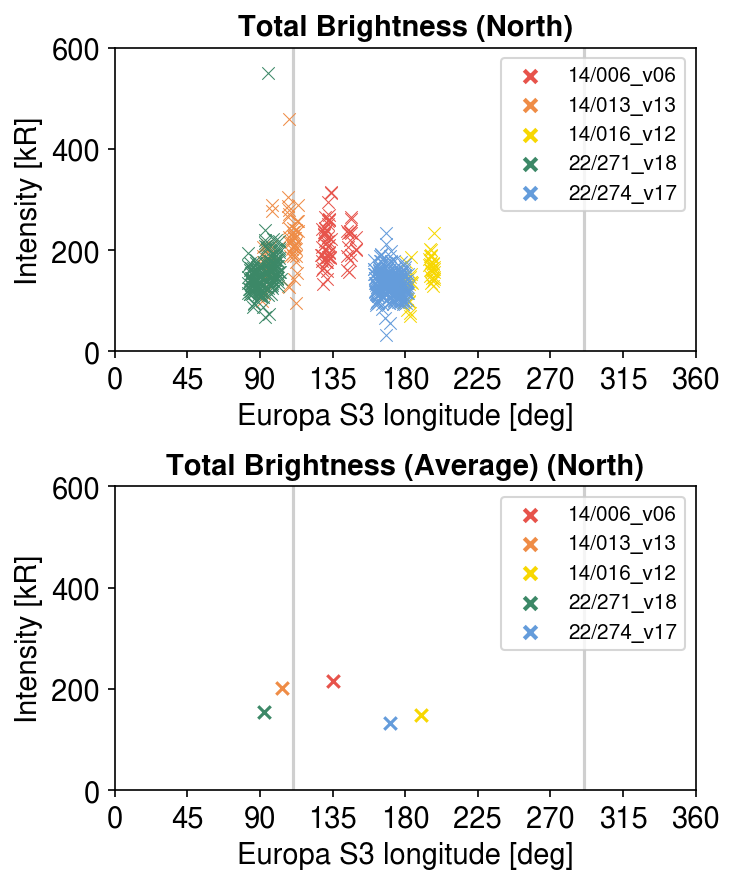

In [5]:
hem = 'North'
if hem == 'North':
    doy = north_doy
elif hem == 'South':
    doy = south_doy
else:
    doy = north_doy+south_doy

fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,6), dpi=150)
ax[0].set_title('Total Brightness ('+hem+')', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,600)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr+b1_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

ax[1].set_title('Total Brightness (Average) ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,600)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b0_ave+b1_ave, marker='x', c=cpalette[i], label=doy[i], zorder=1)
ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for j in range(2):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles, labels=labels, loc='upper right')

fig.tight_layout()
plt.show()

ローカルのバックグラウンド

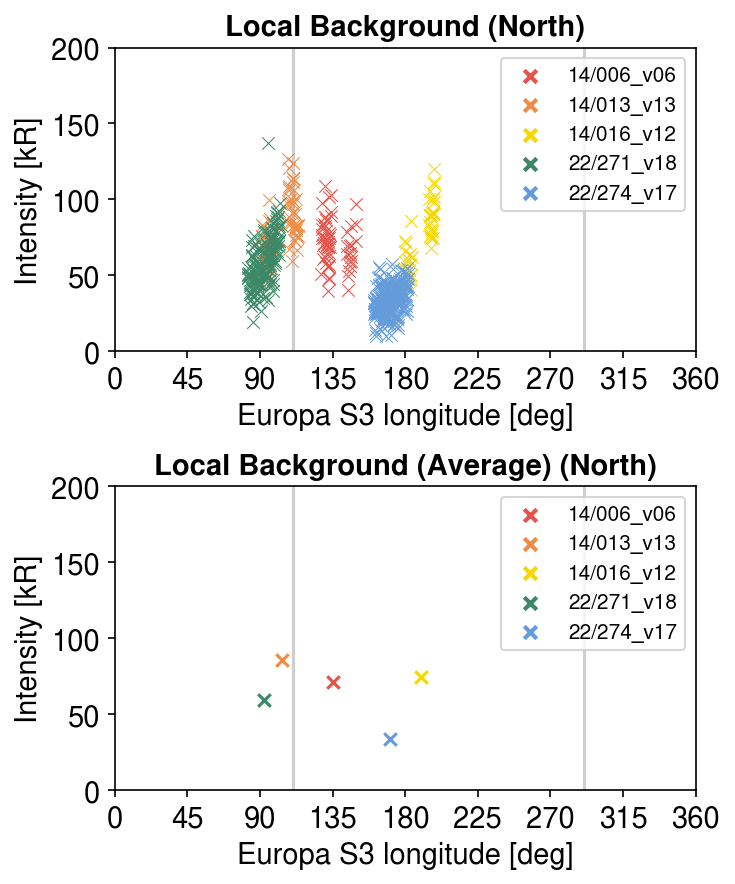

In [6]:
hem = 'North'
if hem == 'North':
    doy = north_doy
elif hem == 'South':
    doy = south_doy
else:
    doy = north_doy+south_doy

fontsize = 14
fig, ax = plt.subplots(2,1, figsize=(5,6), dpi=150)
ax[0].set_title('Local Background ('+hem+')', weight='bold', fontsize=fontsize)
ax[0].set_xlim(0,360)
ax[0].set_ylim(0,200)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[0].set_xticks(np.linspace(0,360,9))
ax[0].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[0].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[0].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[0].tick_params(axis='x', labelsize=fontsize)
ax[0].tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b1_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
ax[0].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
ax[0].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

ax[1].set_title('Local Background (Average) ('+hem+')', weight='bold', fontsize=fontsize)
ax[1].set_xlim(0,360)
ax[1].set_ylim(0,200)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax[1].set_xticks(np.linspace(0,360,9))
ax[1].set_xticklabels(np.linspace(0,360,9, dtype=int))
ax[1].set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax[1].set_ylabel('Intensity [kR]', fontsize=fontsize)
ax[1].tick_params(axis='x', labelsize=fontsize)
ax[1].tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b1_ave, marker='x', c=cpalette[i], label=doy[i], zorder=1)
ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for j in range(2):
    # obtain the handles and labels from the figure
    handles, labels = ax[j].get_legend_handles_labels()
    # copy the handles
    handles = [copy.copy(ha) for ha in handles ]
    # set the linewidths to the copies
    [ha.set_linewidth(2) for ha in handles ]
    ax[j].legend(handles=handles, labels=labels, loc='upper right')

fig.tight_layout()
plt.show()

経度差

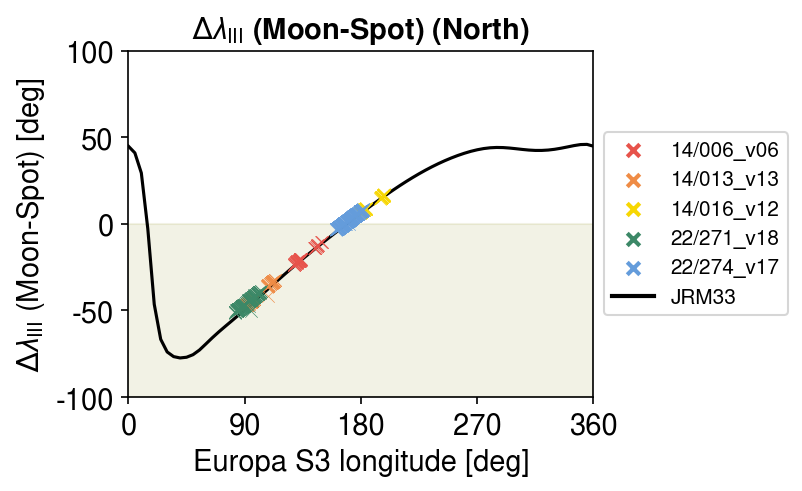

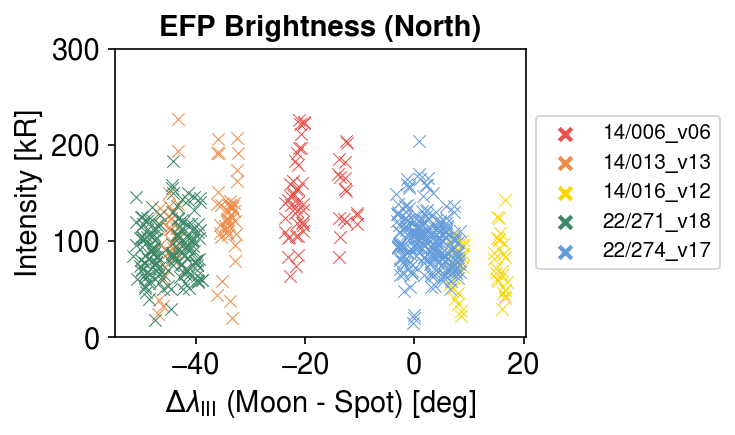

In [7]:
hem = 'North'

# JRM33
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

# 北半球
if hem == 'North':
    doy = north_doy
    satoval = satovalN
    wlon0 = copy.copy(satovalN.wlon[0:4])
    wlon1 = copy.copy(satovalN.wlon[2:])
    euwlon0 = copy.copy(satovalN.euwlon[0:4])
    euwlon1 = copy.copy(satovalN.euwlon[2:])
    euwlon0[3] += 360
    euwlon1[0] += -360
    
    wlon0 = copy.copy(satovalN.wlon)
    euwlon0 = copy.copy(satovalN.euwlon)
    euwlon0[0:3] += -360

# 南半球
elif hem == 'South':
    doy = south_doy
    satoval = satovalS
    wlon0 = copy.copy(satovalS.wlon[0:-1])
    wlon1 = copy.copy(satovalS.wlon[-3:])
    euwlon0 = copy.copy(satovalS.euwlon[0:-1])
    euwlon1 = copy.copy(satovalS.euwlon[-3:])
    euwlon0[-1] += 360
    euwlon1[0] += -360

# 1枚目 EFP Longitude
fontsize = 14
fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
# ax.set_aspect('equal')
ax.set_title('$\\Delta\\lambda_{\\mathrm{III}}$ (Moon-Spot) ('+hem+')', weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
ax.set_ylim(-100,100)
ax.set_xticks(np.linspace(0,360,5))
ax.set_xticklabels(np.linspace(0,360,5,dtype=int))
ax.set_yticks(np.linspace(-100,100,5))
ax.set_yticklabels(np.linspace(-100,100,5,dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\Delta\\lambda_{\\mathrm{III}}$ (Moon-Spot) [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax.scatter(moons30_arr, -(efpwlong0_arr-moons30_arr), marker='x', c=cpalette[i], linewidths=0.3, label=doy[i], zorder=1)
    # ax.plot(moons30_arr, moons30_arr-efpwlong0_arr, color=cpalette[i])
ax.axhspan(-100, 0, color='olive', alpha=0.10, zorder=0.1)
ax.plot(wlon0, -(euwlon0-wlon0), color='k', label='JRM33', zorder=0.5)
# obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(2) for ha in handles ]
ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1., .5))
plt.show()

# 2枚目 System III Difference vs Brightness
fontsize = 14
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=150)
ax.set_title('EFP Brightness ('+hem+')', weight='bold', fontsize=fontsize)
# ax.set_xlim(-60,20)
ax.set_ylim(0,300)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
# ax.set_xticks(np.linspace(0,360,9))
# ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('$\\Delta\\lambda_{\\mathrm{III}}$ (Moon - Spot) [deg]', fontsize=fontsize)
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax.scatter(moons30_arr-efpwlong0_arr, b0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
# obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(2) for ha in handles ]
ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1., .5))
fig.tight_layout()
plt.show()

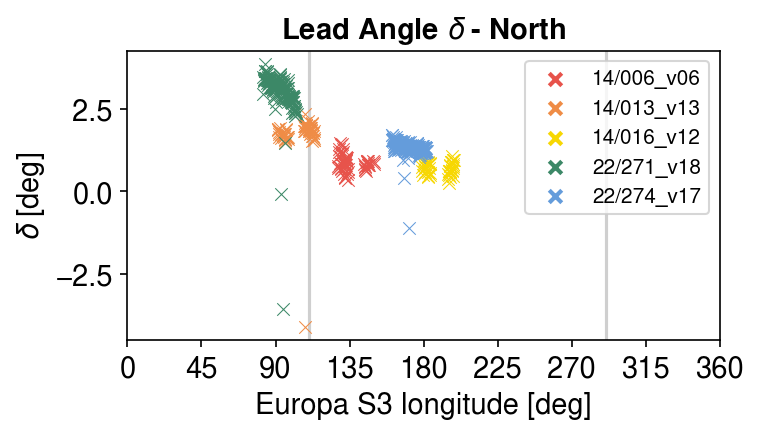

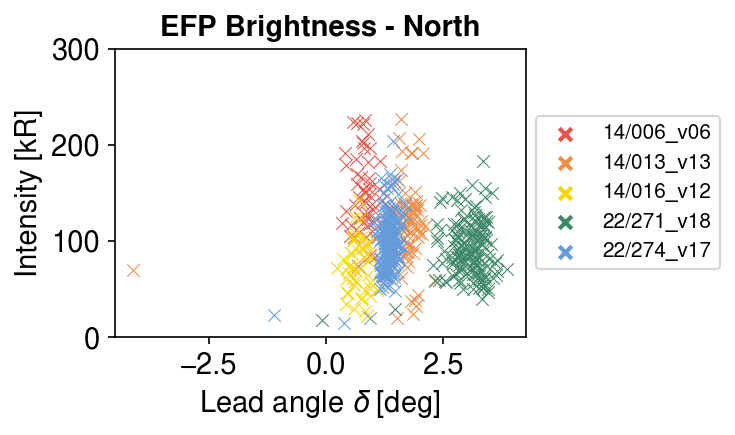

In [8]:
hem = 'North'

# JRM33
satovalN = np.recfromtxt('data/JRM33/satellite_foot_N.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

satovalS = np.recfromtxt('data/JRM33/satellite_foot_S.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

# 北半球
if hem == 'North':
    doy = north_doy
    satoval = satovalN
    wlon0 = copy.copy(satovalN.wlon[0:4])
    wlon1 = copy.copy(satovalN.wlon[2:])
    euwlon0 = copy.copy(satovalN.euwlon[0:4])
    euwlon1 = copy.copy(satovalN.euwlon[2:])
    euwlon0[3] += 360
    euwlon1[0] += -360
    
    wlon0 = copy.copy(satovalN.wlon)
    euwlon0 = copy.copy(satovalN.euwlon)
    euwlon0[0:3] += -360

# 南半球
elif hem == 'South':
    doy = south_doy
    satoval = satovalS
    wlon0 = copy.copy(satovalS.wlon[0:-1])
    wlon1 = copy.copy(satovalS.wlon[-3:])
    euwlon0 = copy.copy(satovalS.euwlon[0:-1])
    euwlon1 = copy.copy(satovalS.euwlon[-3:])
    euwlon0[-1] += 360
    euwlon1[0] += -360

# System III Difference
fontsize = 14
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=150)
ax.set_title('Lead Angle $\\delta$ - '+hem, weight='bold', fontsize=fontsize)
ax.set_xlim(0,360)
# ax.set_ylim(0,200)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
ax.set_xticks(np.linspace(0,360,9))
ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('Europa S3 longitude [deg]', fontsize=fontsize)
ax.set_ylabel('$\\delta$ [deg]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    JRM33wlong_arr = np.zeros(len(utc))
    for j in range(len(utc)):
        JRM33_s3moon, JRM33_s3wlon, JRM33_s3lat = ftpS3.ftpS3().FP(utc[j], satoval, 'EUROPA')
        JRM33wlong_arr[j] = JRM33_s3wlon
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    JRM33wlong_arr = JRM33wlong_arr[idx]
    ax.scatter(moons30_arr, JRM33wlong_arr-efpwlong0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
    # ax[0].plot(moons30_arr, moons30_arr-efpwlong0_arr, color=cpalette[i])
ax.axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
ax.axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)
# obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(2) for ha in handles ]
ax.legend(handles=handles, labels=labels, loc='upper right')
fig.tight_layout()
plt.show()

# System III Difference vs Brightness
fontsize = 14
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=150)
ax.set_title('EFP Brightness - '+hem, weight='bold', fontsize=fontsize)
# ax.set_xlim(0,360)
ax.set_ylim(0,300)
# ax.set_yticks(np.linspace(-10,200,5))
# ax.set_yticklabels(np.linspace(-10,200,5))
# ax.set_xticks(np.linspace(0,360,9))
# ax.set_xticklabels(np.linspace(0,360,9, dtype=int))
ax.set_xlabel('Lead angle $\\delta$ [deg]', fontsize=fontsize)
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
for i in range(len(doy)):
    csvname0 = 'img/red3/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    JRM33wlong_arr = np.zeros(len(utc))
    for j in range(len(utc)):
        JRM33_s3moon, JRM33_s3wlon, JRM33_s3lat = ftpS3.ftpS3().FP(utc[j], satoval, 'EUROPA')
        JRM33wlong_arr[j] = JRM33_s3wlon
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    JRM33wlong_arr = JRM33wlong_arr[idx]
    ax.scatter(JRM33wlong_arr-efpwlong0_arr, b0_arr, marker='x', c=cpalette[i], linewidths=0.5, label=doy[i], zorder=1)
# obtain the handles and labels from the figure
handles, labels = ax.get_legend_handles_labels()
# copy the handles
handles = [copy.copy(ha) for ha in handles ]
# set the linewidths to the copies
[ha.set_linewidth(2) for ha in handles ]
ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1., .5))
fig.tight_layout()
plt.show()

# Fluctuation

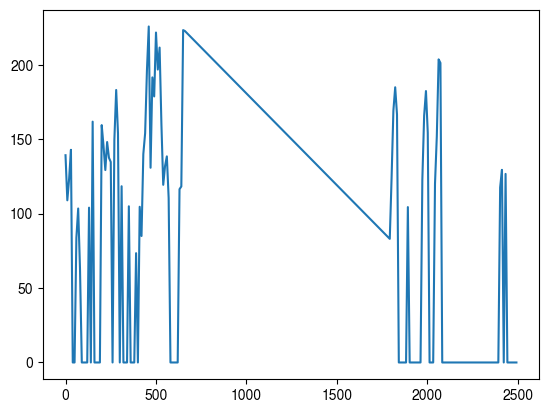

In [23]:
csvname0 = 'img/red3/EUROPA/2014/006_v06/brightness.csv'
utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
et_hst = spice.str2et(utc)-spice.str2et(utc[0])

"""
idx = np.where(b0_arr>0)
et_hst = et_hst[idx]
efplat0_arr = efplat0_arr[idx]
efpwlong0_arr = efpwlong0_arr[idx]
moons30_arr = moons30_arr[idx]
b0_arr = b0_arr[idx]
b1_arr = b1_arr[idx]
"""

plt.plot(et_hst, b0_arr)
plt.show()